# Business Understanding

## New Channels, New Problems
The possibility of making reservations online has completely changed consumer behavior. A large number of reservations are canceled very close to the date or simply result in *no-shows* (when the customer does not show up). Typical reasons for this include changes in plans, scheduling conflicts, etc., which have become increasingly common due to options like canceling reservations without penalties or with a very low cost. This is beneficial for travelers but detrimental to the hotel's revenue.

## Goals and Objectives
- **Objectives:** The main objective of this project is to investigate factors related to cancellations and *no-shows* and to build a machine learning model capable of predicting the probability of these situations occurring.
- **Goals:** (1) Obtain insights from the data to reduce no-shows and identify solutions, (2) build a binary classification model capable of predicting no-shows, and (3) create a *web* application for attendance prediction.

# Understanding the Data
## Features

|Feature|Description|
|---|---|
|``Booking_ID``|Unique identifier of the booking|
|``no_of_adults``|Number of adults|
|``no_of_children``|Number of children|
|``no_of_weekend_nights``|Number of nights during the weekend|
|``no_of_week_nights``|Number of nights during the week|
|``type_of_meal_plan``|Selected meal package|
|``required_car_parking_space``|Flag indicating if the customer needs a parking space|
|``room_type_reserved``|Type of room reserved|
|``lead_time``|Days between booking and arrival at the hotel|
|``arrival_year``|Year of arrival|
|``arrival_month``|Month of arrival|
|``arrival_date``|Date of arrival|
|``market_segment``|Market segment|
|``repeated_guest``|Flag indicating if the customer has made previous bookings|
|``no_of_previous_cancellations``|Number of cancellations before the current booking|
|``no_of_previous_bookings_not_canceled``|Number of previous bookings not canceled before the current booking|
|``avg_price_per_room``|Average booking price (prices are dynamic)|
|``no_of_special_requests``|Number of special requests made by the customer (e.g., sea view, specific floor)|
|``booking_status``|Target variable, flag indicating if the booking was canceled or not|


## Data Loading and Library Import


In [2]:
# Data Manipulation
import pandas as pd
import numpy as np

# EDA
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
import optuna
from lightgbm import LGBMClassifier
from sklearn.metrics import make_scorer, accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from category_encoders import TargetEncoder, OrdinalEncoder

# Notebook config
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fast')
blue_palette = ['#003f5c', '#665191', '#a05195', '#d45087', '#f95d6a', '#ff7c43', '#ffa600']
sns.set_palette(blue_palette)
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)

<Figure size 1000x200 with 0 Axes>

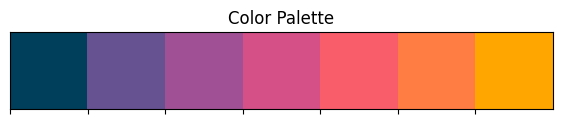

In [3]:
plt.figure(figsize=(10, 2))
sns.palplot(sns.color_palette(blue_palette))
plt.title("Color Palette")
plt.show()

In [4]:
df = pd.read_csv("../data/raw/Hotel Reservations.csv")

## Data Quality

In [5]:
df.shape

(36275, 19)

In [6]:
df.nunique().sort_values()

required_car_parking_space                  2
arrival_year                                2
repeated_guest                              2
booking_status                              2
type_of_meal_plan                           4
no_of_adults                                5
market_segment_type                         5
no_of_children                              6
no_of_special_requests                      6
room_type_reserved                          7
no_of_weekend_nights                        8
no_of_previous_cancellations                9
arrival_month                              12
no_of_week_nights                          18
arrival_date                               31
no_of_previous_bookings_not_canceled       59
lead_time                                 352
avg_price_per_room                       3930
Booking_ID                              36275
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

In [8]:
df.isnull().mean().sort_values(ascending = False)

Booking_ID                              0.0
no_of_adults                            0.0
no_of_children                          0.0
no_of_weekend_nights                    0.0
no_of_week_nights                       0.0
type_of_meal_plan                       0.0
required_car_parking_space              0.0
room_type_reserved                      0.0
lead_time                               0.0
arrival_year                            0.0
arrival_month                           0.0
arrival_date                            0.0
market_segment_type                     0.0
repeated_guest                          0.0
no_of_previous_cancellations            0.0
no_of_previous_bookings_not_canceled    0.0
avg_price_per_room                      0.0
no_of_special_requests                  0.0
booking_status                          0.0
dtype: float64

In [9]:
df.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


### Data Cleaning and Manipulation

To proceed, I see the need for some simple processes:
1. Removing the `Booking_ID` column, as it is not relevant to the analysis;
2. Converting the target variable type to boolean;
3. Creating a month/year column for analyzing temporal trends.

In [10]:
df['booking_status'] = df['booking_status'].map({'Not_Canceled':0, 'Canceled': 1})
df = df.drop(columns = 'Booking_ID', axis = 1)

In [11]:
df['arrival_year_month'] = pd.to_datetime(df['arrival_year'].astype(str) + '-' + df['arrival_month'].astype(str) + '-01')

In [12]:
df.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,arrival_year_month
0,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,0,2017-10-01
1,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,0,2018-11-01
2,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,1,2018-02-01
3,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,1,2018-05-01
4,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,1,2018-04-01


In [13]:
df.to_csv("../data/processed/clean_data.csv", index = False)

## Exploratory Data Analysis

### Descriptive Statistics

In [14]:
df.select_dtypes(include = 'number').describe().T

,count,mean,std,min,25%,50%,75%,max
no_of_adults,36275.0,1.844962,0.518715,0.0,2.0,2.00,2.0,4.0
no_of_children,36275.0,0.105279,0.402648,0.0,0.0,0.00,0.0,10.0
no_of_weekend_nights,36275.0,0.810724,0.870644,0.0,0.0,1.00,2.0,7.0
no_of_week_nights,36275.0,2.204300,1.410905,0.0,1.0,2.00,3.0,17.0
required_car_parking_space,36275.0,0.030986,0.173281,0.0,0.0,0.00,0.0,1.0
lead_time,36275.0,85.232557,85.930817,0.0,17.0,57.00,126.0,443.0
arrival_year,36275.0,2017.820427,0.383836,2017.0,2018.0,2018.00,2018.0,2018.0
arrival_month,36275.0,7.423653,3.069894,1.0,5.0,8.00,10.0,12.0
arrival_date,36275.0,15.596995,8.740447,1.0,8.0,16.00,23.0,31.0
repeated_guest,36275.0,0.025637,0.158053,0.0,0.0,0.00,0.0,1.0


- Only 3% of customers request a parking space;
- On average, bookings are made 85 days in advance; the median suggests a possible imbalance in the distribution of this feature (we will examine this feature visually);
- Only 2% of customers are repeat guests, indicating potential to further explore this group;
- 32% of customers cancel their bookings.

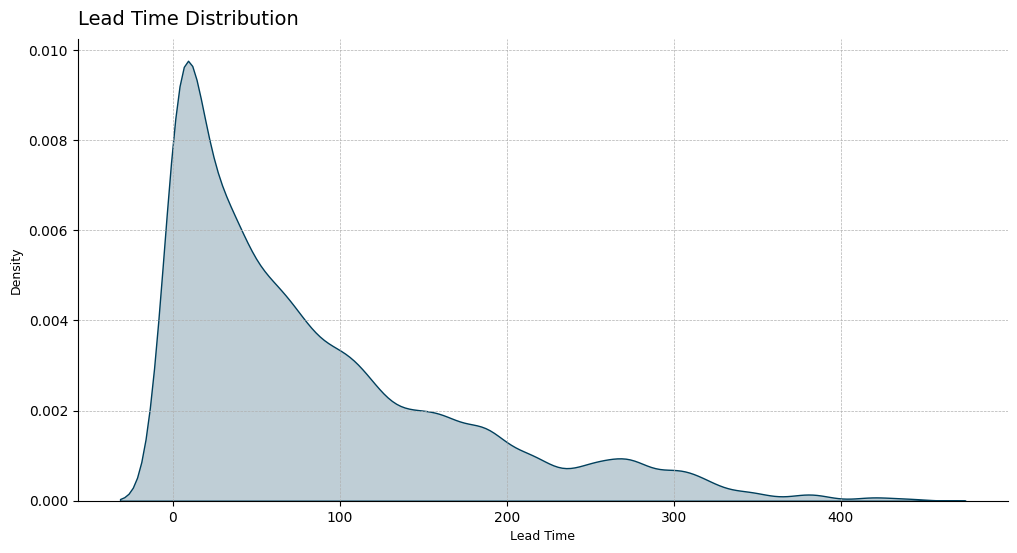

In [15]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.kdeplot(df, x = 'lead_time', fill = True)
ax.set_title("Lead Time Distribution", fontsize = 14, pad = 10, loc = 'left')
ax.set_xlabel("Lead Time", fontsize = 9)
ax.set_ylabel("Density", fontsize = 9)
ax.grid(True, linestyle = '--', linewidth = 0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

### Target Behavior

In [16]:
df['booking_status'].value_counts(1)

booking_status
0    0.672364
1    0.327636
Name: proportion, dtype: float64

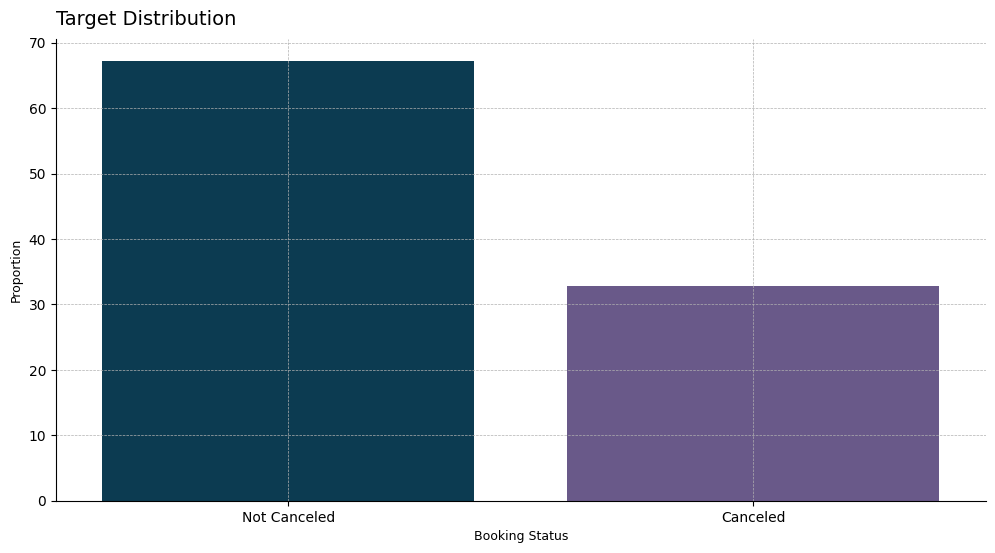

In [17]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.countplot(df, x = 'booking_status', hue = 'booking_status', stat = 'percent')
ax.set_title("Target Distribution", loc = 'left', fontsize = 14, pad = 10)
ax.set_xlabel('Booking Status', fontsize = 9)
ax.set_ylabel('Proportion', fontsize = 9)
ax.set_xticklabels(['Not Canceled', 'Canceled'])
ax.legend().remove()
ax.grid(True, linestyle = '--', linewidth = 0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

### Testing Some Hypotheses

#### Lead Time vs. Cancellations

Bookings made well in advance may have a higher probability of cancellation. Trips are always susceptible to changes in plans and unforeseen events. Let's work on this hypothesis:

- $H_0:$ Lead time does not significantly affect cancellations.
- $H_1:$ A longer lead time increases the probability of cancellation.

In [18]:
from scipy.stats import mannwhitneyu

group_a = df[df['booking_status'] == 1]['lead_time']
group_b = df[df['booking_status'] == 0]['lead_time']

_, p_value = mannwhitneyu(group_a, group_b, alternative='greater')

alpha = 0.05

if p_value < alpha:
    print("We reject H0: A longer lead time increases the probability of cancellation.")
else:
    print("We do not reject H0: Lead time does not significantly affect cancellations.")

We reject H0: A longer lead time increases the probability of cancellation.


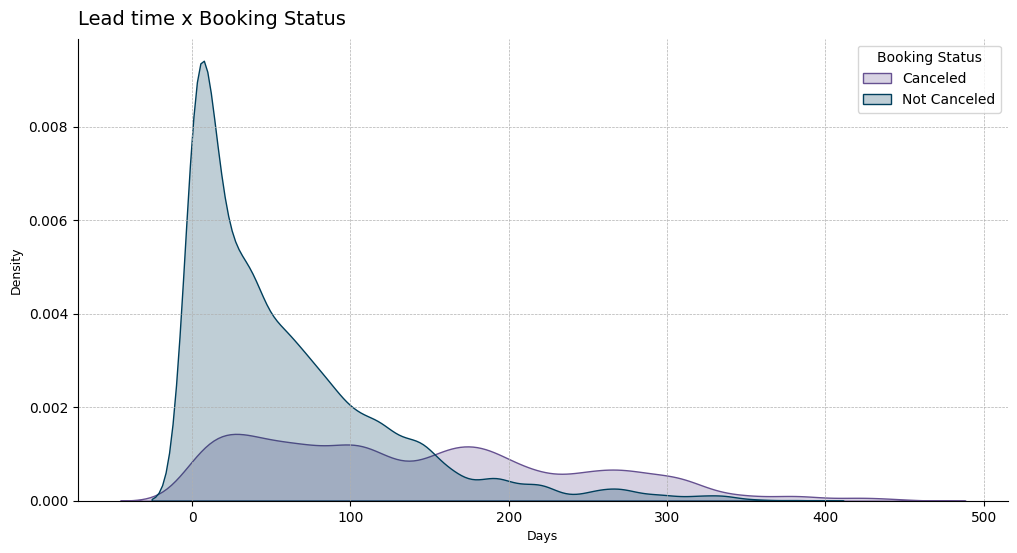

In [210]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.kdeplot(df, x = 'lead_time', hue = 'booking_status', fill = True)
ax.set_title("Lead time x Booking Status", fontsize = 14, pad = 10, loc = 'left')
ax.set_xlabel("Days", fontsize = 9)
ax.set_ylabel("Density", fontsize = 9)
ax.legend(title = 'Booking Status', labels = ['Canceled', 'Not Canceled'])
ax.grid(True, linestyle = '--', linewidth = 0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

Bookings made between 150 and 300 days prior to the arrival date have a higher probability of cancellation. It is advisable to create alerts and confirmations for bookings starting from the 100-day mark.

#### Average Price per Room vs. Cancellations

Since room prices are dynamic, seeing a better offer or realizing a suboptimal choice may lead to cancellations, so a higher-priced room may have a higher probability of cancellation.

- $H_0:$ The average price per room has no significant effect on the probability of cancellation.
- $H_1:$ A higher average price per room is associated with a higher probability of cancellation.

In [19]:
group_a = df[df['booking_status'] == 1]['avg_price_per_room']
group_b = df[df['booking_status'] == 0]['avg_price_per_room']

_, p_value = mannwhitneyu(group_a, group_b, alternative = 'greater')

alpha = 0.05

if p_value < alpha:
    print("We reject H0: A higher average price per room is associated with a higher probability of cancellation.")
else:
    print("We do not reject H0: The average price per room has no significant effect on the probability of cancellation.")

We reject H0: A higher average price per room is associated with a higher probability of cancellation.


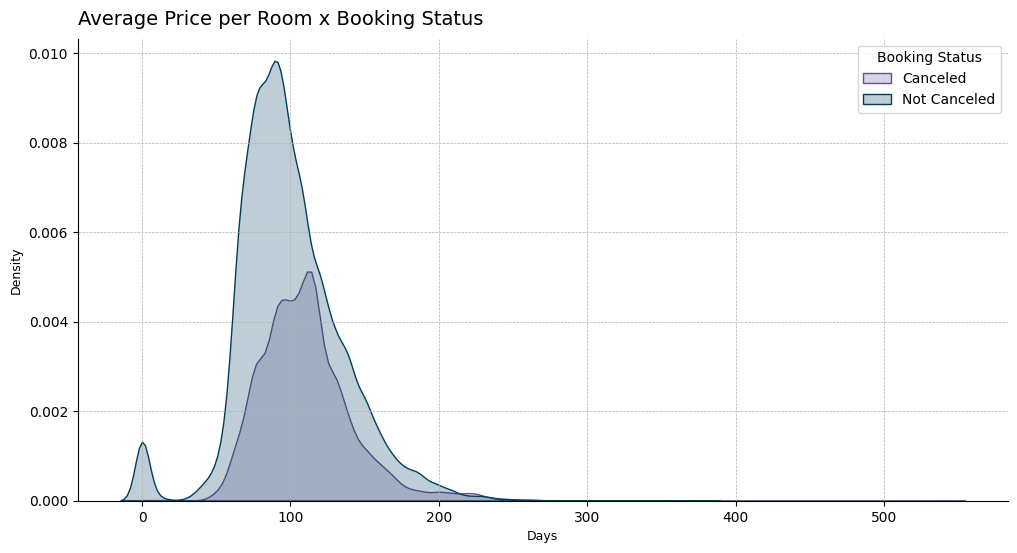

In [212]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.kdeplot(df, x = 'avg_price_per_room', hue = 'booking_status', fill = True)
ax.set_title("Average Price per Room x Booking Status", fontsize = 14, pad = 10, loc = 'left')
ax.set_xlabel("Days", fontsize = 9)
ax.set_ylabel("Density", fontsize = 9)
ax.legend(title = 'Booking Status', labels = ['Canceled', 'Not Canceled'])
ax.grid(True, linestyle = '--', linewidth = 0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

#### Number of Children vs. Cancellations

A higher number of children makes travel planning more challenging, as children tend to get sick more often, among other potential unforeseen events.

- $H_0:$ The number of children does not have a significant effect on cancellations.
- $H_1:$ A higher number of children increases the probability of cancellation.

In [20]:

group_a = df[df['booking_status'] == 1]['no_of_children']
group_b = df[df['booking_status'] == 0]['no_of_children']

_, p_value = mannwhitneyu(group_a, group_b, alternative = 'greater')

alpha = 0.05

if p_value < alpha:
    print("We reject H0: A higher number of children increases the probability of cancellation.")
else:
    print("We do not reject H0: The number of children does not have a significant effect on cancellations.")

We reject H0: A higher number of children increases the probability of cancellation.


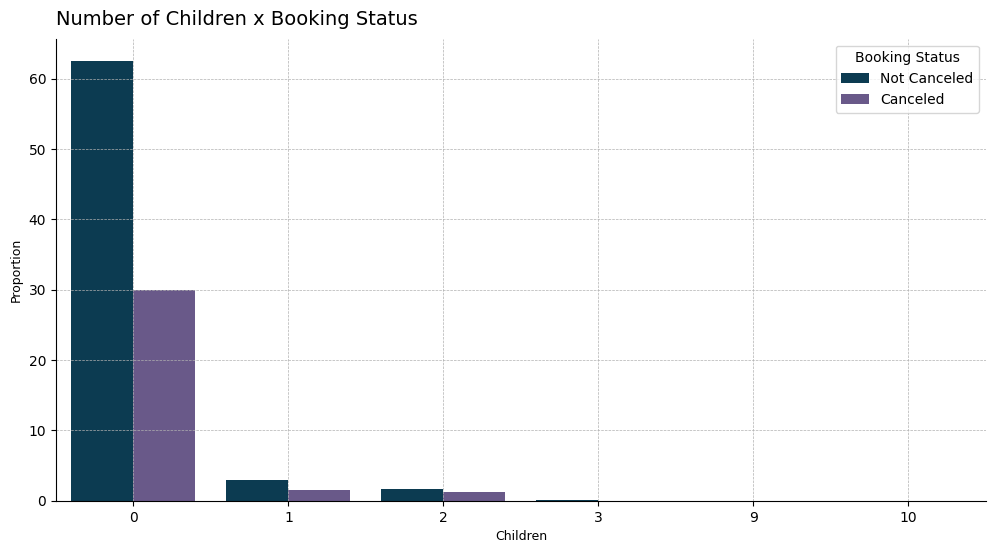

In [214]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.countplot(x = df['no_of_children'], hue = df['booking_status'], stat = 'percent')
ax.set_title("Number of Children x Booking Status", fontsize = 14, pad = 10, loc = 'left')
ax.set_xlabel("Children", fontsize = 9)
ax.set_ylabel("Proportion", fontsize = 9)
ax.legend(title = 'Booking Status', labels = ['Not Canceled', 'Canceled'])
ax.grid(True, linestyle = '--', linewidth = 0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

As we can see, there is a higher proportion of cancellations among people with children.

#### Room Type vs. Cancellation

Room type may also be related to cancellations, and testing this hypothesis could highlight areas for service improvement.

- $H_0:$ Room type is independent of booking status.
- $H_1:$ Room type is not independent of booking status.

In [21]:
from scipy.stats import chi2_contingency

contigency_table = pd.crosstab(df['room_type_reserved'], df['booking_status'])
chi2, p_value, dof, expected = chi2_contingency(contigency_table)

alpha = 0.05
if p_value < alpha:
    print("We reject H0: Room Type and Booking Status are related.")
else:
    print("We do not reject H0: : There is not enough evidence to assert that Room Type and Booking Status are related.")

We reject H0: Room Type and Booking Status are related.


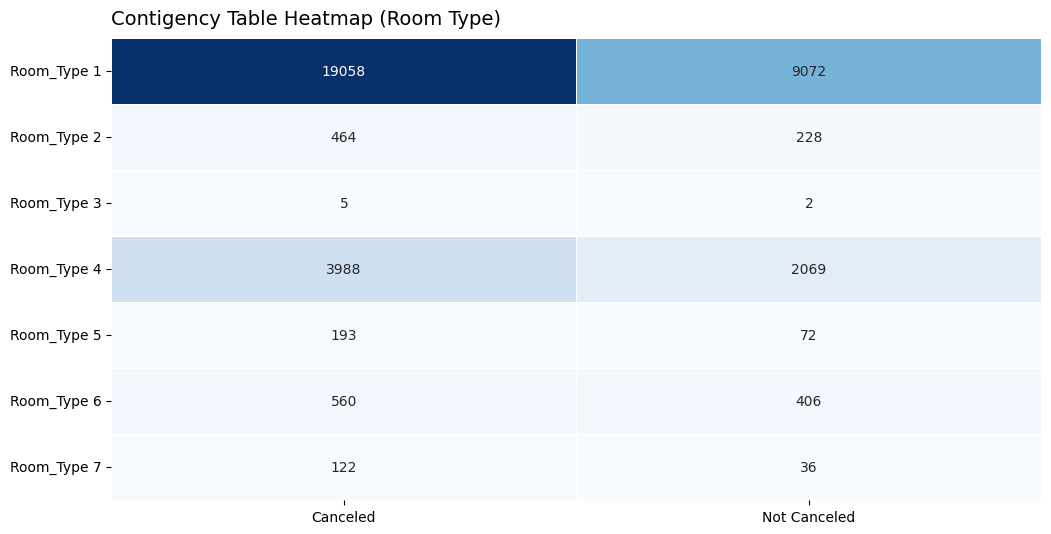

In [216]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.heatmap(contigency_table, annot = True, linewidths=.5, fmt = 'd', cmap = 'Blues', cbar=False)
ax.set_title("Contigency Table Heatmap (Room Type)", fontsize = 14, pad = 10, loc = 'left')
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticklabels(['Canceled', 'Not Canceled'])
plt.show()

Types 1 and 4 have the most reservations; however, while Type 1 has a low cancellation rate, Type 4 has more cancellations than successful bookings, warranting deeper investigation. Type 6 has the highest proportional cancellation rate, which is another key point to consider.

#### Market Segment vs. Booking Status

We cannot conclude the hypothesis testing without examining market segments, so let's test:

- $H_0:$ Market segment is independent of booking status.
- $H_1:$ Market segment is not independent of booking status.

In [22]:
contigency_table_2 = pd.crosstab(df['market_segment_type'], df['booking_status'])
chi2, p_value, dof, expected = chi2_contingency(contigency_table_2)

alpha = 0.05
if p_value < alpha:
    print("We reject H0: Marketing Segment and Booking Status are related.")
else:
    print("We do not reject H0: : There is not enough evidence to assert that Marketing Segment and Booking Status are related.")

We reject H0: Marketing Segment and Booking Status are related.


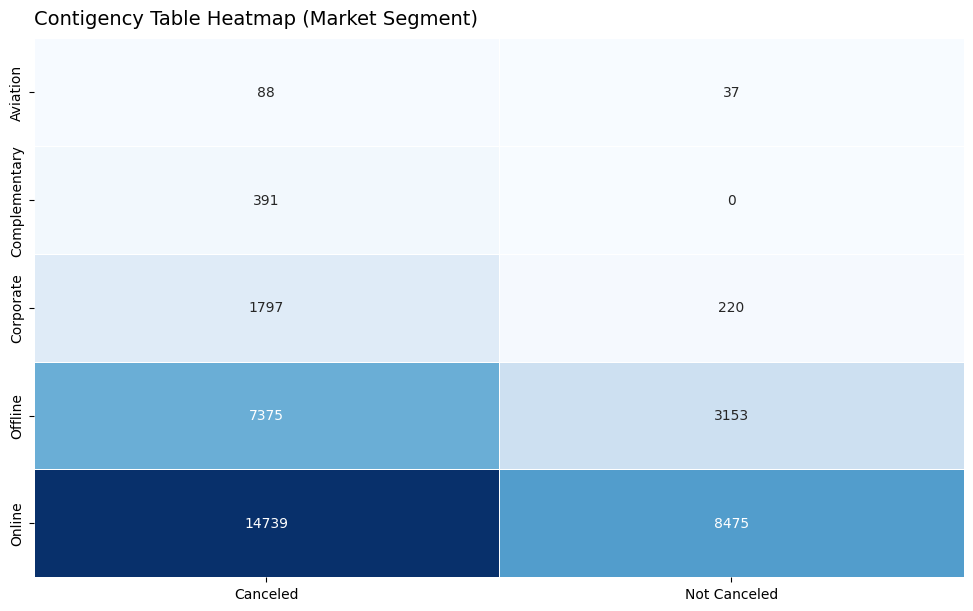

In [218]:
fig, ax = plt.subplots(figsize = (12, 7))

sns.heatmap(contigency_table_2, annot = True, linewidths=.5, fmt = 'd', cmap = 'Blues', cbar=False)
ax.set_title("Contigency Table Heatmap (Market Segment)", fontsize = 14, pad = 10, loc = 'left')
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticklabels(['Canceled', 'Not Canceled'])
plt.show()

As expected, the online segment is the most popular and also has the highest cancellation rate. Corporate and Complementary segments have the fewest cancellations.

### Observing over time

In [219]:
df_time = df.groupby("arrival_year_month").agg(cancellations = ('booking_status', 'sum')).sort_values(by = 'arrival_year_month').reset_index()

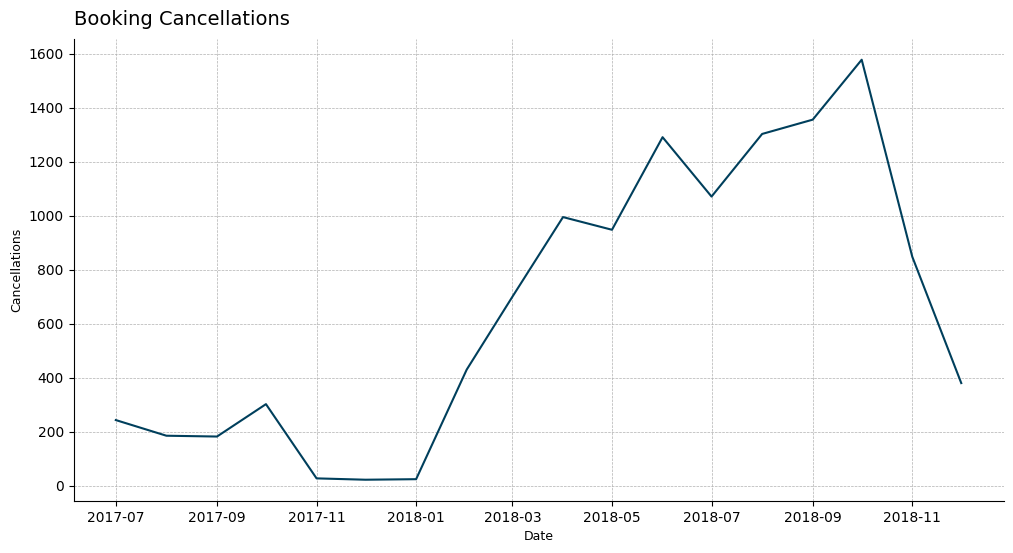

In [220]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.lineplot(df_time, x = 'arrival_year_month', y = 'cancellations')
ax.set_title("Booking Cancellations", fontsize = 14, pad = 10, loc = 'left')
ax.set_xlabel("Date", fontsize = 9)
ax.set_ylabel("Cancellations", fontsize = 9)
ax.grid(True, linestyle = '--', linewidth = 0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

We observe a growth in the cancellation count, with a trend showing that cancellations peak from September to November, further investigation is needed to identify the factors behind this pattern.

### EDA Conclusions

- Reservations with long lead times need to be closely tracked. Simple actions, such as periodic confirmation messages or emails, can help manage cancellations, as we’ve seen that the probability of cancellation rises with longer lead times.
- A higher number of children increases the probability of cancellation. This should also be tracked, and solutions like basic health support options for children could be considered.
- Rooms of Types 4 and 6 should undergo price revisions and quality improvements to help reduce their high cancellation rates.
- The Online segment is the most popular and has the highest cancellation rate. The Complementary and Corporate segments have the lowest cancellation rates, so rewarding these segments may be beneficial.
- Bookings for September, October, and November require monitoring for external factors that may cause cancellations, such as climate issues and regional events.

# Data Preparation

In [24]:
features = df.drop(columns = ['booking_status', 'arrival_year', 'arrival_year_month'], axis = 1).columns.to_list()
target = 'booking_status'

X = df[features]
y = df[target]

In [25]:
cat_features = ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type', 'repeated_guest', 'required_car_parking_space']
num_features = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'lead_time', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'avg_price_per_room', 'no_of_special_requests']
ordinal_features = ['arrival_date', 'arrival_month']

In [26]:
cat_transformer = Pipeline([
    ('imput_cat', CategoricalImputer(imputation_method='frequent')),
    ('encoder_cat', TargetEncoder())
])

num_transformer = Pipeline([
    ('imput_num', MeanMedianImputer(imputation_method='median'))
])

ordinal_transformer = Pipeline([
    ('imput_or', MeanMedianImputer(imputation_method='median')),
    ('encoder_or', OrdinalEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_features),
        ('num', num_transformer, num_features),
        ('ordinal', ordinal_transformer, ordinal_features)
    ]
)

# Modeling

## Base model

In [29]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size = 0.25, random_state=21)

In [32]:
model = LGBMClassifier(learning_rate = 0.5, n_estimators = 100, num_leaves = 31, random_state = 42)
base_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', model)
])

base_clf.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 7113, number of negative: 14652
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 21765, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.326809 -> initscore=-0.722653
[LightGBM] [Info] Start training from score -0.722653


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imput_cat',
                                                                   CategoricalImputer(imputation_method='frequent')),
                                                                  ('encoder_cat',
                                                                   TargetEncoder())]),
                                                  ['type_of_meal_plan',
                                                   'room_type_reserved',
                                                   'market_segment_type',
                                                   'repeated_guest',
                                                   'required_car_parking_space']),
                                                 ('num',
                                                  Pipeline(steps=[('imput_num',
                                                                   MeanMedianImputer(...
                                                   'no_of_weekend_nights',
                                                   'no_of_week_nights',
                                                   'lead_time',
                                                   'no_of_previous_cancellations',
                                                   'no_of_previous_bookings_not_canceled',
                                                   'avg_price_per_room',
                                                   'no_of_special_requests']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('imput_or',
                                                                   MeanMedianImputer()),
                                                                  ('encoder_or',
                                                                   OrdinalEncoder())]),
                                                  ['arrival_date',
                                                   'arrival_month'])])),
                ('classifier',
                 LGBMClassifier(learning_rate=0.5, random_state=42))])

In [33]:
# Predictions

y_proba = base_clf.predict_proba(X_val)[:,1]
y_pred = base_clf.predict(X_val)

In [34]:
print(f"Validation Set - Results\n{'-' * 25}")
print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_val, y_pred):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_val, y_proba):.4f}")

Validation Set - Results
-------------------------
Accuracy: 0.8933
F1 Score: 0.8312
ROC AUC Score: 0.9476


In [35]:
print(f"{"="*15} Classification Report {"="*15}\n")
print(classification_report(y_val, y_pred))

=============== Classification Report ===============

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      4899
           1       0.85      0.81      0.83      2356

    accuracy                           0.89      7255
   macro avg       0.88      0.87      0.88      7255
weighted avg       0.89      0.89      0.89      7255



The base model has good overall accuracy; however, we can optimize it around the F1 Score to achieve a better balance between precision and recall.

## Hyperparameter tuning

In [253]:
def objective(trial):
    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "n_estimators": 1000,
        "verbosity": -1,
        "bagging_freq": 1,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LGBMClassifier(**params, random_state = 42))
    ])
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    f1 = f1_score(y_val, predictions)
    return f1

In [254]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2024-10-30 17:44:15,283] A new study created in memory with name: no-name-e48af14b-4eb9-4464-92f5-a1d54937e20b


[I 2024-10-30 17:44:29,240] Trial 0 finished with value: 0.8324157674521031 and parameters: {'learning_rate': 0.08995407768207367, 'num_leaves': 899, 'subsample': 0.7052346507709861, 'colsample_bytree': 0.4342606578684499, 'min_data_in_leaf': 22}. Best is trial 0 with value: 0.8324157674521031.


[I 2024-10-30 17:44:38,433] Trial 1 finished with value: 0.8330411919368974 and parameters: {'learning_rate': 0.05160292823835453, 'num_leaves': 441, 'subsample': 0.7975489611097022, 'colsample_bytree': 0.5761822418050327, 'min_data_in_leaf': 59}. Best is trial 1 with value: 0.8330411919368974.


[I 2024-10-30 17:44:44,213] Trial 2 finished with value: 0.821826280623608 and parameters: {'learning_rate': 0.019226475204940165, 'num_leaves': 322, 'subsample': 0.4172849025183933, 'colsample_bytree': 0.6051645474245976, 'min_data_in_leaf': 69}. Best is trial 1 with value: 0.8330411919368974.


[I 2024-10-30 17:44:47,210] Trial 3 finished with value: 0.7405469678953627 and parameters: {'learning_rate': 0.0052310107002111325, 'num_leaves': 813, 'subsample': 0.09364277620666303, 'colsample_bytree': 0.3171259658037189, 'min_data_in_leaf': 46}. Best is trial 1 with value: 0.8330411919368974.


[I 2024-10-30 17:44:55,816] Trial 4 finished with value: 0.7997278294397823 and parameters: {'learning_rate': 0.002311136848296331, 'num_leaves': 222, 'subsample': 0.5453677171156148, 'colsample_bytree': 0.9249119249292506, 'min_data_in_leaf': 48}. Best is trial 1 with value: 0.8330411919368974.


[I 2024-10-30 17:45:05,497] Trial 5 finished with value: 0.83568281938326 and parameters: {'learning_rate': 0.024897117251061886, 'num_leaves': 603, 'subsample': 0.518087119599135, 'colsample_bytree': 0.5257327420813548, 'min_data_in_leaf': 35}. Best is trial 5 with value: 0.83568281938326.


[I 2024-10-30 17:45:10,383] Trial 6 finished with value: 0.8029823768639855 and parameters: {'learning_rate': 0.012208283617501757, 'num_leaves': 643, 'subsample': 0.3863151137190089, 'colsample_bytree': 0.3750842809783542, 'min_data_in_leaf': 78}. Best is trial 5 with value: 0.83568281938326.


[I 2024-10-30 17:45:32,518] Trial 7 finished with value: 0.8420356906807667 and parameters: {'learning_rate': 0.02723007976714423, 'num_leaves': 604, 'subsample': 0.9016600229695916, 'colsample_bytree': 0.7284604615309098, 'min_data_in_leaf': 19}. Best is trial 7 with value: 0.8420356906807667.


[I 2024-10-30 17:45:34,117] Trial 8 finished with value: 0.22664165103189493 and parameters: {'learning_rate': 0.00340426107414246, 'num_leaves': 770, 'subsample': 0.06947719583773697, 'colsample_bytree': 0.11294132271049759, 'min_data_in_leaf': 81}. Best is trial 7 with value: 0.8420356906807667.


[I 2024-10-30 17:45:38,536] Trial 9 finished with value: 0.7653014265991717 and parameters: {'learning_rate': 0.0018668930921122177, 'num_leaves': 118, 'subsample': 0.500727658515591, 'colsample_bytree': 0.9322827088655936, 'min_data_in_leaf': 95}. Best is trial 7 with value: 0.8420356906807667.


[I 2024-10-30 17:45:40,924] Trial 10 finished with value: 0.8344459279038718 and parameters: {'learning_rate': 0.039508784312644527, 'num_leaves': 22, 'subsample': 0.9702997813151651, 'colsample_bytree': 0.7341943072811894, 'min_data_in_leaf': 1}. Best is trial 7 with value: 0.8420356906807667.


[I 2024-10-30 17:45:55,390] Trial 11 finished with value: 0.8387665198237886 and parameters: {'learning_rate': 0.021850414821999415, 'num_leaves': 578, 'subsample': 0.701072582468807, 'colsample_bytree': 0.7438298461304809, 'min_data_in_leaf': 30}. Best is trial 7 with value: 0.8420356906807667.


[I 2024-10-30 17:46:11,615] Trial 12 finished with value: 0.8445034284450342 and parameters: {'learning_rate': 0.008808583552638027, 'num_leaves': 457, 'subsample': 0.9170043550796534, 'colsample_bytree': 0.7602643560780677, 'min_data_in_leaf': 13}. Best is trial 12 with value: 0.8445034284450342.


[I 2024-10-30 17:46:26,573] Trial 13 finished with value: 0.8474276882313977 and parameters: {'learning_rate': 0.007449099025034568, 'num_leaves': 411, 'subsample': 0.925052790755639, 'colsample_bytree': 0.7474042324137619, 'min_data_in_leaf': 5}. Best is trial 13 with value: 0.8474276882313977.


[I 2024-10-30 17:46:40,575] Trial 14 finished with value: 0.8478164975738862 and parameters: {'learning_rate': 0.00681644874893244, 'num_leaves': 382, 'subsample': 0.9945007005142789, 'colsample_bytree': 0.8447669219822008, 'min_data_in_leaf': 1}. Best is trial 14 with value: 0.8478164975738862.


[I 2024-10-30 17:46:52,796] Trial 15 finished with value: 0.8413186813186814 and parameters: {'learning_rate': 0.010139881892441534, 'num_leaves': 334, 'subsample': 0.9964684904389305, 'colsample_bytree': 0.9935839085746521, 'min_data_in_leaf': 4}. Best is trial 14 with value: 0.8478164975738862.


[I 2024-10-30 17:47:03,940] Trial 16 finished with value: 0.8036508307980341 and parameters: {'learning_rate': 0.0011032699517052435, 'num_leaves': 301, 'subsample': 0.7999969656857477, 'colsample_bytree': 0.8858614455187753, 'min_data_in_leaf': 14}. Best is trial 14 with value: 0.8478164975738862.


[I 2024-10-30 17:47:19,902] Trial 17 finished with value: 0.8454384410983171 and parameters: {'learning_rate': 0.004986790278371883, 'num_leaves': 435, 'subsample': 0.81891735661319, 'colsample_bytree': 0.8363722102197795, 'min_data_in_leaf': 1}. Best is trial 14 with value: 0.8478164975738862.


[I 2024-10-30 17:47:26,055] Trial 18 finished with value: 0.8139954853273138 and parameters: {'learning_rate': 0.006586150279587627, 'num_leaves': 1013, 'subsample': 0.21531388630969245, 'colsample_bytree': 0.6278835669568662, 'min_data_in_leaf': 32}. Best is trial 14 with value: 0.8478164975738862.


[I 2024-10-30 17:47:32,119] Trial 19 finished with value: 0.7992633517495396 and parameters: {'learning_rate': 0.01422336435291671, 'num_leaves': 170, 'subsample': 0.7108302724434423, 'colsample_bytree': 0.22243964257231152, 'min_data_in_leaf': 11}. Best is trial 14 with value: 0.8478164975738862.


[I 2024-10-30 17:47:46,642] Trial 20 finished with value: 0.8261261261261261 and parameters: {'learning_rate': 0.0036727783763806482, 'num_leaves': 722, 'subsample': 0.6217057956096912, 'colsample_bytree': 0.819518113420208, 'min_data_in_leaf': 27}. Best is trial 14 with value: 0.8478164975738862.


[I 2024-10-30 17:48:02,254] Trial 21 finished with value: 0.8456078083407276 and parameters: {'learning_rate': 0.00547472008988974, 'num_leaves': 426, 'subsample': 0.8381906495255417, 'colsample_bytree': 0.8191073265243459, 'min_data_in_leaf': 1}. Best is trial 14 with value: 0.8478164975738862.


[I 2024-10-30 17:48:20,513] Trial 22 finished with value: 0.8469184890656064 and parameters: {'learning_rate': 0.007243260431037664, 'num_leaves': 496, 'subsample': 0.8922359205538345, 'colsample_bytree': 0.8045365475243378, 'min_data_in_leaf': 7}. Best is trial 14 with value: 0.8478164975738862.


[I 2024-10-30 17:48:38,951] Trial 23 finished with value: 0.8440895985806165 and parameters: {'learning_rate': 0.00721735852554883, 'num_leaves': 526, 'subsample': 0.9052767547583184, 'colsample_bytree': 0.6821022361455659, 'min_data_in_leaf': 10}. Best is trial 14 with value: 0.8478164975738862.


[I 2024-10-30 17:48:51,721] Trial 24 finished with value: 0.8226887003126395 and parameters: {'learning_rate': 0.003238980323211725, 'num_leaves': 370, 'subsample': 0.9980720666402967, 'colsample_bytree': 0.9793673648218806, 'min_data_in_leaf': 39}. Best is trial 14 with value: 0.8478164975738862.


[I 2024-10-30 17:49:01,649] Trial 25 finished with value: 0.843591440547099 and parameters: {'learning_rate': 0.014539379839160581, 'num_leaves': 255, 'subsample': 0.8714945900526401, 'colsample_bytree': 0.6594108518657892, 'min_data_in_leaf': 21}. Best is trial 14 with value: 0.8478164975738862.


[I 2024-10-30 17:49:20,609] Trial 26 finished with value: 0.8456109395677106 and parameters: {'learning_rate': 0.008446472665376677, 'num_leaves': 535, 'subsample': 0.9363366243175895, 'colsample_bytree': 0.8642485390063346, 'min_data_in_leaf': 9}. Best is trial 14 with value: 0.8478164975738862.


[I 2024-10-30 17:49:42,140] Trial 27 finished with value: 0.8195523069894929 and parameters: {'learning_rate': 0.00211137002143171, 'num_leaves': 657, 'subsample': 0.7613452572971124, 'colsample_bytree': 0.8014730088852753, 'min_data_in_leaf': 19}. Best is trial 14 with value: 0.8478164975738862.


[I 2024-10-30 17:49:51,526] Trial 28 finished with value: 0.8136603254641301 and parameters: {'learning_rate': 0.00412415143882135, 'num_leaves': 381, 'subsample': 0.6291444725584626, 'colsample_bytree': 0.4758165060791676, 'min_data_in_leaf': 40}. Best is trial 14 with value: 0.8478164975738862.


[I 2024-10-30 17:50:08,107] Trial 29 finished with value: 0.8351648351648352 and parameters: {'learning_rate': 0.06927593370863983, 'num_leaves': 494, 'subsample': 0.7536912446180927, 'colsample_bytree': 0.5326519754159313, 'min_data_in_leaf': 25}. Best is trial 14 with value: 0.8478164975738862.


In [255]:
print(f"Best hyperparameters: {study.best_params}")
print(f"Best F1 Score: {study.best_value}")

Best hyperparameters: {'learning_rate': 0.00681644874893244, 'num_leaves': 382, 'subsample': 0.9945007005142789, 'colsample_bytree': 0.8447669219822008, 'min_data_in_leaf': 1}
Best F1 Score: 0.8478164975738862


In [ ]:
model = LGBMClassifier(**study.best_params, n_estimators=1000, random_state=42)

clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', model)
])

clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imput_cat',
                                                                   CategoricalImputer(imputation_method='frequent')),
                                                                  ('encoder_cat',
                                                                   TargetEncoder())]),
                                                  ['type_of_meal_plan',
                                                   'room_type_reserved',
                                                   'market_segment_type',
                                                   'repeated_guest',
                                                   'required_car_parking_space']),
                                                 ('num',
                                                  Pipeline(steps=[('imput_num',
                                                                   MeanMedianImputer(...
                                                   'no_of_special_requests']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('imput_or',
                                                                   MeanMedianImputer()),
                                                                  ('encoder_or',
                                                                   OrdinalEncoder())]),
                                                  ['arrival_date',
                                                   'arrival_month'])])),
                ('classifier',
                 LGBMClassifier(colsample_bytree=0.8447669219822008,
                                learning_rate=0.00681644874893244,
                                min_data_in_leaf=1, n_estimators=1000,
                                num_leaves=382, random_state=42,
                                subsample=0.9945007005142789))])

In [259]:
y_proba = clf.predict_proba(X_val)[:,1]
y_pred = clf.predict(X_val)

In [260]:
print(f"Validation Set - Results\n{'-' * 25}")
print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_val, y_pred):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_val, y_proba):.4f}")

Validation Set - Results
-------------------------
Accuracy: 0.9056
F1 Score: 0.8486
ROC AUC Score: 0.9572


In [261]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      4899
           1       0.89      0.81      0.85      2356

    accuracy                           0.91      7255
   macro avg       0.90      0.88      0.89      7255
weighted avg       0.90      0.91      0.90      7255



# Evaluation
## Test set metrics

In [262]:
y_proba = clf.predict_proba(X_test)[:,1]
y_pred = clf.predict(X_test)

In [264]:
print(f"Test Set - Results\n{'-'*25}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

Test Set - Results
-------------------------
Accuracy: 0.9016
F1 Score: 0.8468
ROC AUC: 0.9607


In [266]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.94      0.93      4839
           1       0.88      0.82      0.85      2416

    accuracy                           0.90      7255
   macro avg       0.90      0.88      0.89      7255
weighted avg       0.90      0.90      0.90      7255



### The best threshold

In [267]:
thresholds = np.arange(0.0, 1.01, 0.01)

f1_scores = []

for threshold in thresholds:
    y_predict = (y_proba > threshold).astype(int)

    f1 = f1_score(y_test, y_predict)
    f1_scores.append(f1)

best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

print(f"Best threshold: {best_threshold}")
print(f"Best F1 Score: {best_f1:.4f}")

Best threshold: 0.47000000000000003
Best F1 Score: 0.8494


## Cross validation

In [270]:
scoring = make_scorer(f1_score)
cv = StratifiedKFold(n_splits=5, shuffle = True, random_state = 42)

scores = cross_val_score(clf, X_train, y_train, cv = cv, scoring = scoring)
print(f"Average F1 Score: {scores.mean()}")
print(f"F1 Score Standard Deviation: {scores.std()}")

Average F1 Score: 0.8297261349486893
F1 Score Standard Deviation: 0.0056888996059496115


## Visualizations 

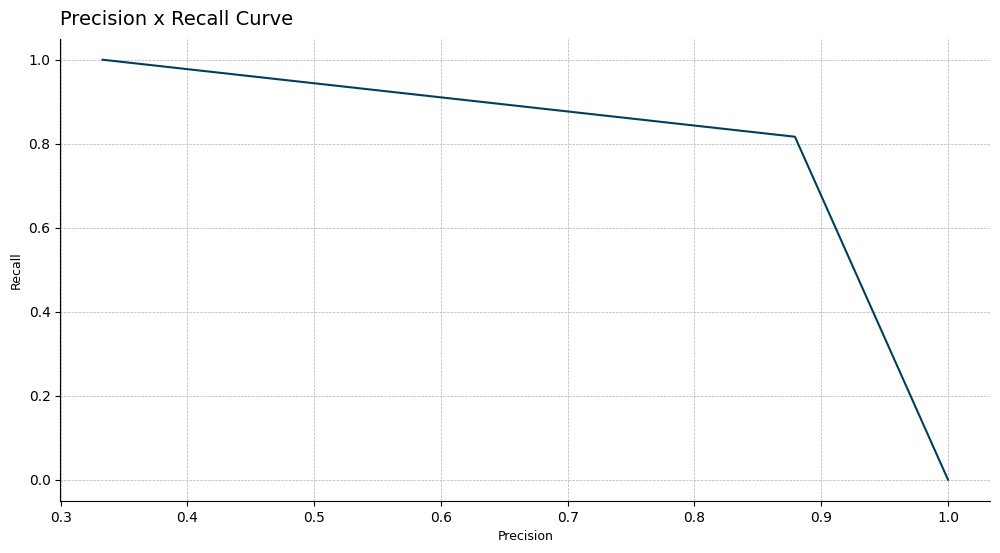

In [290]:
precision, recall, thres = precision_recall_curve(y_test, y_pred)

fig, ax = plt.subplots(figsize = (12, 6))

sns.lineplot(x = precision, y = recall)
ax.set_title("Precision x Recall Curve", fontsize = 14, pad = 10, loc = 'left')
ax.set_xlabel("Precision", fontsize = 9)
ax.set_ylabel("Recall", fontsize = 9)
ax.grid(True, linestyle = '--', linewidth = 0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [273]:
curve = roc_curve(y_test, y_proba)

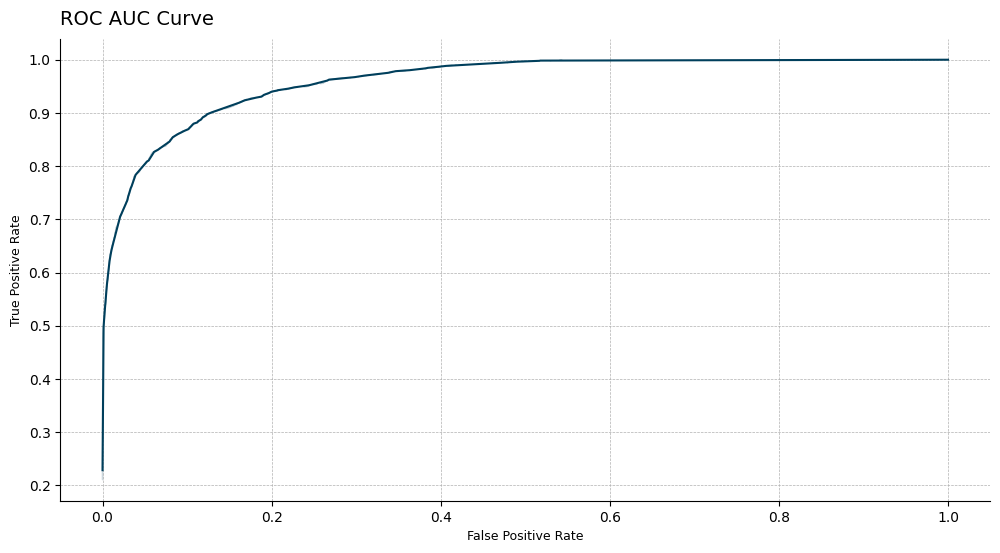

In [275]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.lineplot(x = curve[0], y = curve[1])
ax.set_title(f"ROC AUC Curve", fontsize = 14, pad = 10, loc = 'left')
ax.set_xlabel("False Positive Rate", fontsize = 9)
ax.set_ylabel("True Positive Rate", fontsize = 9)
ax.grid(True, linestyle = '--', linewidth = 0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

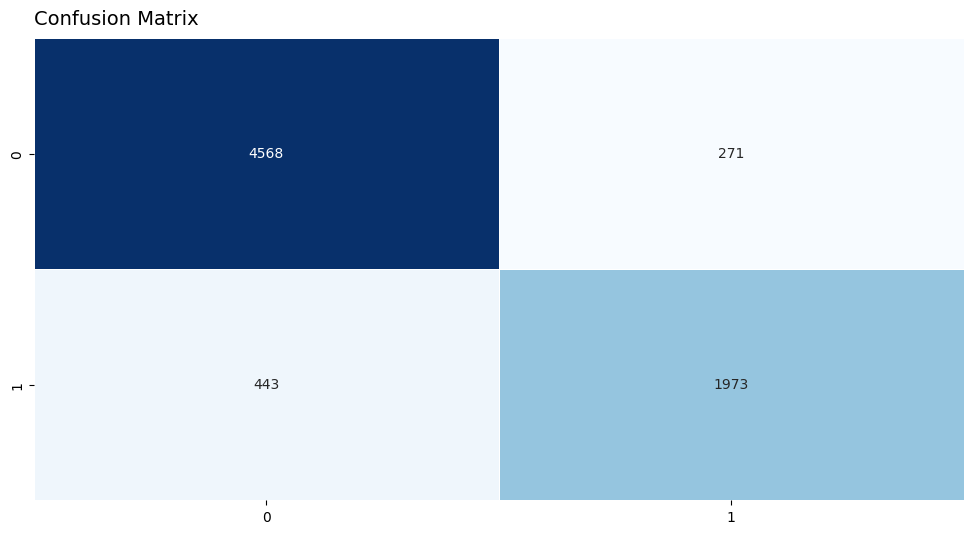

In [293]:
cf = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize = (12, 6))
sns.heatmap(cf, annot = True, fmt = 'd', linewidths=0.5, cmap = 'Blues', cbar = False)
ax.set_title("Confusion Matrix", fontsize = 14, pad = 10, loc = 'left')
plt.show()

## About the classifier

The model has shown no signs of overfitting. It has high accuracy and a low number of false negatives, which could otherwise result in greater revenue losses. With the model built, we can now proceed to save it as a `.pkl` file and create the Streamlit web app.
